# Strategy 1 & 2: HYG Trading Strategies

Implementation of Strategy 1 and Strategy 2 based on BMOM (Blended Momentum) signals.

## Strategy 1 Logic:

```
thresh = -0.03

if (((SPY.BMOM(i-1) > thresh) && (SPY.BMOM(i) < thresh) && (HYG.BMOM(i) < thresh)) ||
    ((HYG.BMOM(i-1) > thresh) && (HYG.BMOM(i) < thresh) && (SPY.BMOM(i) < thresh))) &&
    (HYG.mom240(i) < 0)
    HYG_Strat1_Wgt = 0;
else
    if HYG.BMOM(i) > 0
        HYG_Strat1_Wgt = 1;
    else
        HYG_Strat1_Wgt(i) = HYG_Strat1_Wgt(i-1);
    end
end
```

## Strategy 2 Logic:

```
drawdiffthresh = 0.10

If (Strat1_drawdown - HYG_drawdown) > drawdiffthresh:
    HYG_Strat2_Wgt = 1  (override to long)
Else:
    Use same rules as Strat1 (signal = 0 or 1)
```

**Free Parameters:**
- w1, w2, w3, w4 (BMOM weights)
- thresh (threshold for exit)
- drawdiffthresh (drawdown differential threshold)
- mom240 length (momentum period for HYG in Strat1)

## Step 1: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the HYG (MLH5A4) Price History data
hyg_df = pd.read_csv('MLH5A4_Price_History(Fixed Income) 1.csv', skiprows=15)
hyg_df['Date'] = pd.to_datetime(hyg_df['Date'], format='%m/%d/%y')
hyg_df = hyg_df.set_index('Date')[['Price']]
hyg_df = hyg_df.rename(columns={'Price': 'HYG'})
hyg_df['HYG'] = pd.to_numeric(hyg_df['HYG'], errors='coerce')
hyg_df = hyg_df.dropna()

# Load the SPY data from new CSV file
spy_df = pd.read_csv('SPY.csv')
spy_df['Date'] = pd.to_datetime(spy_df['Date'], format='%Y%m%d')
spy_df = spy_df.set_index('Date')[['SPY_adj_close']]
spy_df = spy_df.rename(columns={'SPY_adj_close': 'SPY'})
spy_df['SPY'] = pd.to_numeric(spy_df['SPY'], errors='coerce')
spy_df = spy_df.dropna()

print("Data loaded successfully!")
print(f"HYG: {len(hyg_df)} rows, {hyg_df.index.min().strftime('%Y-%m-%d')} to {hyg_df.index.max().strftime('%Y-%m-%d')}")
print(f"SPY: {len(spy_df)} rows, {spy_df.index.min().strftime('%Y-%m-%d')} to {spy_df.index.max().strftime('%Y-%m-%d')}")

# Align to common dates
common_dates = hyg_df.index.intersection(spy_df.index)
portfolio = pd.DataFrame(index=common_dates)
portfolio['HYG'] = hyg_df.reindex(common_dates)['HYG']
portfolio['SPY'] = spy_df.reindex(common_dates)['SPY']
portfolio = portfolio.dropna()

print(f"\nData aligned to common dates!")
print(f"Date range: {portfolio.index.min().strftime('%Y-%m-%d')} to {portfolio.index.max().strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(portfolio)}")

FileNotFoundError: [Errno 2] No such file or directory: 'MLH5A4_Price_History(Fixed Income) 1.csv'

## Step 2: Calculate Momentum and BMOM

BMOM formula: 
$$BMOM(t) = 0.15 \cdot Mom_{20}(t) + 0.35 \cdot Mom_{60}(t) + 0.35 \cdot Mom_{120}(t) + 0.15 \cdot Mom_{240}(t)$$

Where momentum is calculated as:
$$Mom_n(t) = \frac{Price(t)}{Price(t-n)} - 1$$

In [ ]:
# BMOM weights
w1, w2, w3, w4 = 0.15, 0.35, 0.35, 0.15

def calculate_bmom(prices):
    """Calculate Blended Momentum for a price series"""
    mom_20 = prices.pct_change(20)
    mom_60 = prices.pct_change(60)
    mom_120 = prices.pct_change(120)
    mom_240 = prices.pct_change(240)
    return w1 * mom_20 + w2 * mom_60 + w3 * mom_120 + w4 * mom_240

# Calculate BMOM for both assets
portfolio['HYG_BMOM'] = calculate_bmom(portfolio['HYG'])
portfolio['SPY_BMOM'] = calculate_bmom(portfolio['SPY'])

# Also store mom_240 separately for exit condition
portfolio['HYG_mom240'] = portfolio['HYG'].pct_change(240)

print("BMOM calculation complete!")
print(f"\nFirst valid BMOM date: {portfolio[['HYG_BMOM', 'SPY_BMOM']].dropna().index.min().strftime('%Y-%m-%d')}")
print(f"\nHYG BMOM statistics:")
print(portfolio['HYG_BMOM'].describe())
print(f"\nSPY BMOM statistics:")
print(portfolio['SPY_BMOM'].describe())

BMOM calculation complete!

First valid BMOM date: 1997-12-11

HYG BMOM statistics:
count    7023.000000
mean        0.001396
std         0.046633
min        -0.285716
25%        -0.020629
50%         0.003676
75%         0.022162
max         0.193940
Name: HYG_BMOM, dtype: float64

SPY BMOM statistics:
count    7023.000000
mean        0.041475
std         0.081773
min        -0.400788
25%         0.002987
50%         0.056170
75%         0.094777
max         0.233374
Name: SPY_BMOM, dtype: float64


## Step 3: Implement Strategy 1

### Strategy Rules:

**Exit Condition (Weight = 0):**
- (SPY.BMOM(i-1) > -0.03 AND SPY.BMOM(i) < -0.03 AND HYG.BMOM(i) < -0.03) OR
- (HYG.BMOM(i-1) > -0.03 AND HYG.BMOM(i) < -0.03 AND SPY.BMOM(i) < -0.03)
- AND HYG.mom240(i) < 0

**Entry Condition (Weight = 1):**
- HYG.BMOM(i) > 0

**Hold Condition:**
- Otherwise, maintain previous weight

In [ ]:
def strategy_1(df, threshold=-0.03):
    """
    Implement Strategy 1 based on the pseudocode.
    
    thresh = -0.03;
    
    if (((SPY.BMOM(i-1) > thresh) && (SPY.BMOM(i) < thresh) && (HYG.BMOM(i) < thresh)) ||
        ((HYG.BMOM(i-1) > thresh) && (HYG.BMOM(i) < thresh) && (SPY.BMOM(i) < thresh))) &&
        (HYG.mom240(i) < 0)
        HYG_Strat1_Wgt = 0;
    else
        if HYG.BMOM(i) > 0
            HYG_Strat1_Wgt = 1;
        else
            HYG_Strat1_Wgt(i) = HYG_Strat1_Wgt(i-1);
        end
    end
    """
    hyg_bmom = df['HYG_BMOM']
    spy_bmom = df['SPY_BMOM']
    hyg_mom240 = df['HYG_mom240']
    
    signal = pd.Series(0, index=df.index)
    
    for i in range(1, len(df)):
        # Current and previous BMOM values
        hyg_curr = hyg_bmom.iloc[i]
        hyg_prev = hyg_bmom.iloc[i-1]
        spy_curr = spy_bmom.iloc[i]
        spy_prev = spy_bmom.iloc[i-1]
        mom240_curr = hyg_mom240.iloc[i]
        
        # Skip if NaN
        if pd.isna(hyg_curr) or pd.isna(hyg_prev) or pd.isna(spy_curr) or pd.isna(spy_prev) or pd.isna(mom240_curr):
            signal.iloc[i] = signal.iloc[i-1]
            continue
        
        # Exit condition 1: SPY crossed below threshold and both below threshold
        spy_crosses_below = (spy_prev > threshold) and (spy_curr < threshold) and (hyg_curr < threshold)
        
        # Exit condition 2: HYG crossed below threshold and both below threshold
        hyg_crosses_below = (hyg_prev > threshold) and (hyg_curr < threshold) and (spy_curr < threshold)
        
        # Combined exit condition with mom240 < 0
        exit_condition = (spy_crosses_below or hyg_crosses_below) and (mom240_curr < 0)
        
        if exit_condition:
            signal.iloc[i] = 0
        elif hyg_curr > 0:
            signal.iloc[i] = 1
        else:
            signal.iloc[i] = signal.iloc[i-1]
    
    return signal

# Apply Strategy 1
print("Running Strategy 1...")
portfolio['HYG_signal'] = strategy_1(portfolio, threshold=-0.03)

# Calculate returns
portfolio['HYG_return'] = portfolio['HYG'].pct_change()

# Strategy returns - use NEXT day signal (shift by 1 day for realistic trading)
portfolio['HYG_strat1_return'] = portfolio['HYG_return'] * portfolio['HYG_signal'].shift(1).fillna(0)

print("\nStrategy 1 completed!")
print(f"Total trading days: {len(portfolio)}")

# Signal distribution
signal_counts = portfolio['HYG_signal'].value_counts()
long_pct = signal_counts.get(1, 0) / len(portfolio) * 100
out_pct = signal_counts.get(0, 0) / len(portfolio) * 100

print(f"\nSignal Distribution:")
print(f"  Long (1): {signal_counts.get(1, 0)} days ({long_pct:.1f}%)")
print(f"  Out (0):  {signal_counts.get(0, 0)} days ({out_pct:.1f}%)")

Running Strategy 1...

Strategy 1 completed!
Total trading days: 7263

Signal Distribution:
  Long (1): 5575 days (76.8%)
  Out (0):  1688 days (23.2%)


## Step 4: Analyze Strategy Weights

In [ ]:
# Display data with signals
print("Sample of strategy signals:")
print("="*80)
display_cols = ['HYG', 'HYG_BMOM', 'SPY_BMOM', 'HYG_mom240', 'HYG_signal']
print(portfolio[display_cols].head(20))

Sample of strategy signals:
               HYG  HYG_BMOM  SPY_BMOM  HYG_mom240  HYG_signal
Date                                                          
1996-12-31   99.99       NaN       NaN         NaN           0
1997-01-02   99.90       NaN       NaN         NaN           0
1997-01-03   99.89       NaN       NaN         NaN           0
1997-01-06   99.78       NaN       NaN         NaN           0
1997-01-07   99.70       NaN       NaN         NaN           0
1997-01-08   99.69       NaN       NaN         NaN           0
1997-01-09   99.78       NaN       NaN         NaN           0
1997-01-10   99.64       NaN       NaN         NaN           0
1997-01-13   99.63       NaN       NaN         NaN           0
1997-01-14   99.80       NaN       NaN         NaN           0
1997-01-15   99.85       NaN       NaN         NaN           0
1997-01-16   99.83       NaN       NaN         NaN           0
1997-01-17   99.84       NaN       NaN         NaN           0
1997-01-20   99.87       Na

## Step 5: Show Examples of Each Signal Type

In [ ]:
# Examples of Exit signals (signal = 0)
print("Examples of EXIT signals (signal = 0):")
print("="*80)
exit_signals = portfolio[portfolio['HYG_signal'] == 0].head(10)
print(exit_signals[['HYG', 'HYG_BMOM', 'SPY_BMOM', 'HYG_mom240', 'HYG_signal']])

Examples of EXIT signals (signal = 0):
              HYG  HYG_BMOM  SPY_BMOM  HYG_mom240  HYG_signal
Date                                                         
1996-12-31  99.99       NaN       NaN         NaN           0
1997-01-02  99.90       NaN       NaN         NaN           0
1997-01-03  99.89       NaN       NaN         NaN           0
1997-01-06  99.78       NaN       NaN         NaN           0
1997-01-07  99.70       NaN       NaN         NaN           0
1997-01-08  99.69       NaN       NaN         NaN           0
1997-01-09  99.78       NaN       NaN         NaN           0
1997-01-10  99.64       NaN       NaN         NaN           0
1997-01-13  99.63       NaN       NaN         NaN           0
1997-01-14  99.80       NaN       NaN         NaN           0


In [ ]:
# Examples of Entry signals (signal = 1)
print("Examples of ENTRY signals (signal = 1):")
print("="*80)
entry_signals = portfolio[portfolio['HYG_signal'] == 1].head(10)
print(entry_signals[['HYG', 'HYG_BMOM', 'SPY_BMOM', 'HYG_mom240', 'HYG_signal']])

Examples of ENTRY signals (signal = 1):
               HYG  HYG_BMOM  SPY_BMOM  HYG_mom240  HYG_signal
Date                                                          
1997-12-12  101.72  0.001689  0.081186    0.018218           1
1997-12-15  101.67  0.001192  0.089258    0.017820           1
1997-12-16  101.68  0.001881  0.094740    0.019042           1
1997-12-17  101.61  0.001421  0.087853    0.019157           1
1997-12-18  101.65  0.001969  0.083727    0.019661           1
1997-12-19  101.67  0.002102  0.069902    0.018942           1
1997-12-22  101.61  0.001381  0.064660    0.019771           1
1997-12-23  101.54  0.000317  0.040356    0.019171           1
1997-12-24  101.52  0.000888  0.041854    0.017234           1
1997-12-26  101.52  0.000285  0.037732    0.016725           1


In [ ]:
# Show signal transitions
portfolio['Signal_Change'] = portfolio['HYG_signal'].diff()
transitions = portfolio[portfolio['Signal_Change'] != 0].copy()

print(f"Total signal transitions: {len(transitions)}")
print("\nFirst 20 signal transitions:")
print("="*80)
print(transitions[['HYG', 'HYG_BMOM', 'SPY_BMOM', 'HYG_mom240', 'HYG_signal', 'Signal_Change']].head(20))

Total signal transitions: 22

First 20 signal transitions:
               HYG  HYG_BMOM  SPY_BMOM  HYG_mom240  HYG_signal  Signal_Change
Date                                                                         
1996-12-31   99.99       NaN       NaN         NaN           0            NaN
1997-12-12  101.72  0.001689  0.081186    0.018218           1            1.0
1998-08-31   94.30 -0.070391 -0.099967   -0.078382           0           -1.0
1999-03-31   95.16  0.001963  0.161389   -0.070703           1            1.0
1999-10-15   90.40 -0.036940 -0.048060   -0.010941           0           -1.0
2001-01-17   85.76  0.002347 -0.047507   -0.050697           1            1.0
2002-10-08   86.17 -0.037017 -0.197246   -0.014862           0           -1.0
2002-11-19   89.41  0.000045 -0.100599   -0.038292           1            1.0
2007-08-15   96.79 -0.046175 -0.030603   -0.023113           0           -1.0
2008-06-06   94.69  0.000902 -0.026426   -0.056591           1            1.0
2008-

## Equity Curve: Strategy 1 vs Buy & Hold

First strategy signal date: 1997-12-12


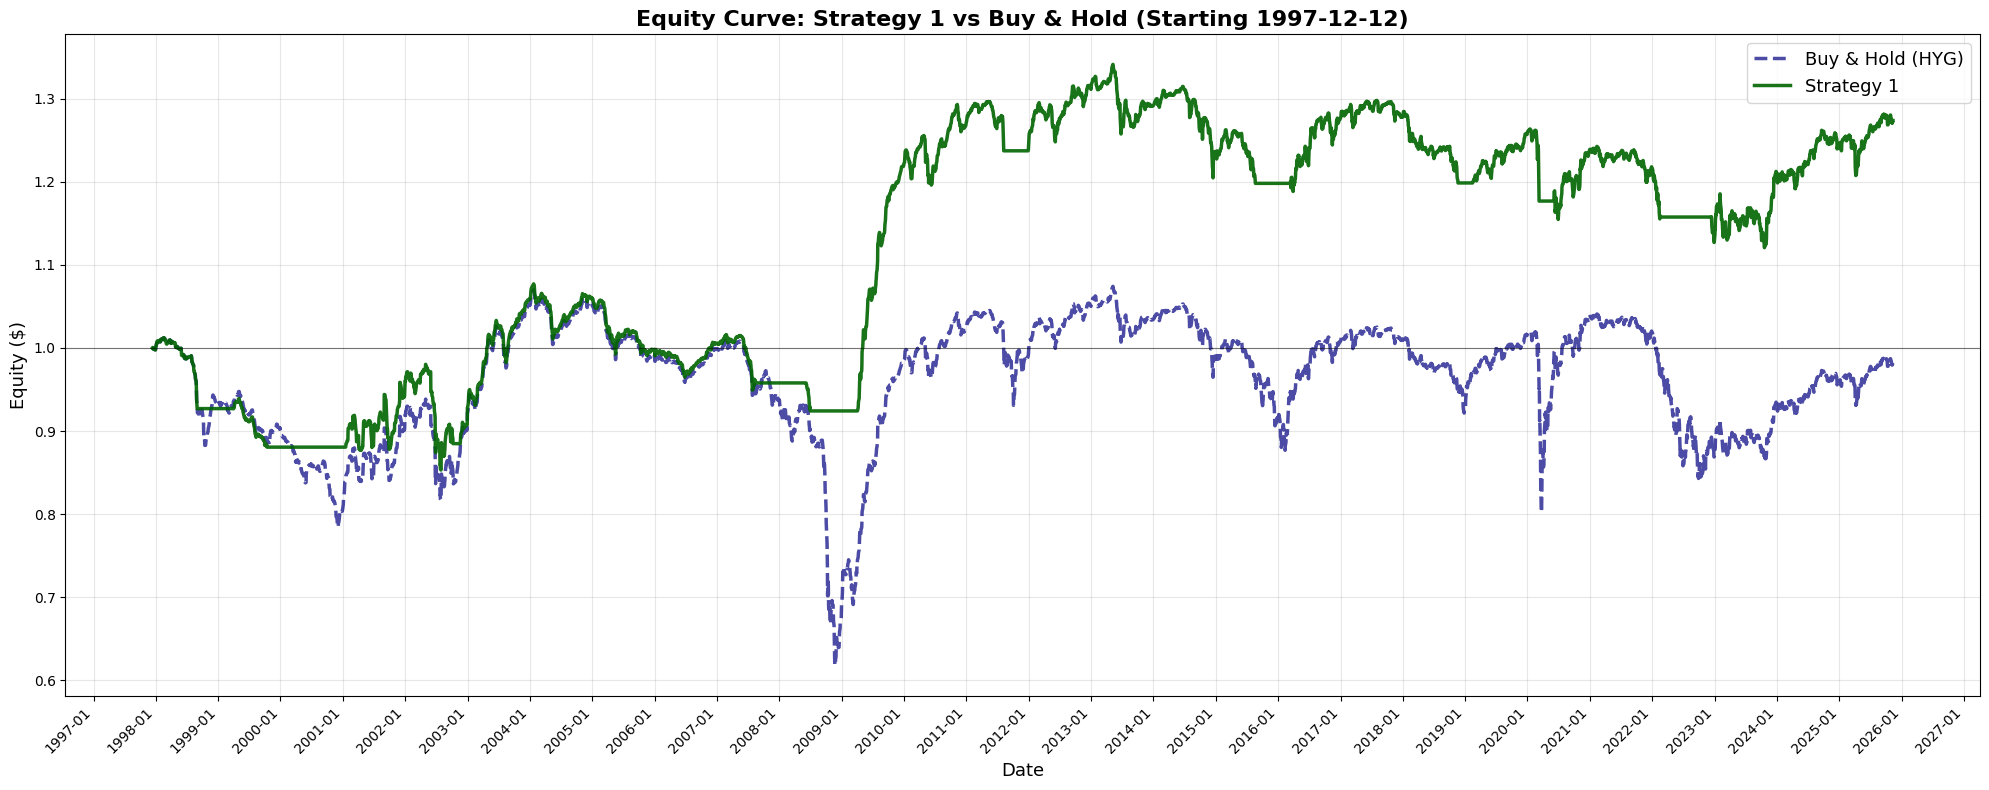


PERFORMANCE METRICS
Period: 1997-12-12 to 2025-11-11
Total days: 7022

Metric                                 Buy & Hold         Strategy 1
Annualized Return                         -0.07%             0.87%
Annualized Volatility                      5.14%             3.57%
Sharpe Ratio                               -0.01              0.24


In [ ]:
# Performance metrics function
def calc_metrics(returns, equity):
    """Calculate performance metrics"""
    total_ret = equity.iloc[-1] / equity.iloc[0] - 1
    ann_ret = (equity.iloc[-1] / equity.iloc[0]) ** (252 / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    return total_ret, ann_ret, ann_vol, sharpe

# Calculate equity curves
portfolio['HYG_equity'] = (1 + portfolio['HYG_return']).cumprod()
portfolio['strat1_equity'] = (1 + portfolio['HYG_strat1_return'].fillna(0)).cumprod()

# Find first valid signal date
first_signal_date = portfolio[portfolio['HYG_signal'] == 1].index.min()
print(f"First strategy signal date: {first_signal_date.strftime('%Y-%m-%d')}")

# Filter data from first signal
plot_data = portfolio[portfolio.index >= first_signal_date].copy()

# Normalize to start at $1
bah_start = plot_data['HYG_equity'].iloc[0]
strat1_start = plot_data['strat1_equity'].iloc[0]

plot_data['bah_norm'] = plot_data['HYG_equity'] / bah_start
plot_data['strat1_norm'] = plot_data['strat1_equity'] / strat1_start

# Calculate metrics
bah_metrics = calc_metrics(plot_data['HYG_return'], plot_data['bah_norm'])
strat1_metrics = calc_metrics(plot_data['HYG_strat1_return'], plot_data['strat1_norm'])

# Plot equity curve
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(plot_data.index, plot_data['bah_norm'], linewidth=2.5, color='navy', 
        label='Buy & Hold (HYG)', alpha=0.7, linestyle='--')
ax.plot(plot_data.index, plot_data['strat1_norm'], linewidth=2.5, color='darkgreen', 
        label='Strategy 1', alpha=0.9)

ax.axhline(y=1, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

ax.set_title(f'Equity Curve: Strategy 1 vs Buy & Hold (Starting {first_signal_date.strftime("%Y-%m-%d")})', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Equity ($)', fontsize=13)
ax.legend(loc='best', fontsize=13)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display performance comparison
print("\n" + "="*70)
print("PERFORMANCE METRICS")
print("="*70)
print(f"Period: {plot_data.index.min().strftime('%Y-%m-%d')} to {plot_data.index.max().strftime('%Y-%m-%d')}")
print(f"Total days: {len(plot_data)}")

print("\n" + "="*70)
print(f"{'Metric':<30} {'Buy & Hold':>18} {'Strategy 1':>18}")
print("="*70)
print(f"{'Annualized Return':<30} {bah_metrics[1]:>17.2%} {strat1_metrics[1]:>17.2%}")
print(f"{'Annualized Volatility':<30} {bah_metrics[2]:>17.2%} {strat1_metrics[2]:>17.2%}")
print(f"{'Sharpe Ratio':<30} {bah_metrics[3]:>17.2f} {strat1_metrics[3]:>17.2f}")
print("="*70)

In [ ]:
# Strategy 2 parameters
drawdiffthresh = 0.10

def calculate_drawdown(equity_series):
    """Calculate drawdown from equity series"""
    running_max = equity_series.expanding().max()
    return (equity_series - running_max) / running_max

# Calculate equity curves for drawdown calculation
hyg_bah_equity = (1 + portfolio['HYG_return']).cumprod()
strat1_equity_full = (1 + portfolio['HYG_strat1_return'].fillna(0)).cumprod()

# Calculate drawdowns
strat1_dd = calculate_drawdown(strat1_equity_full)
bah_dd = calculate_drawdown(hyg_bah_equity)
dd_diff = strat1_dd - bah_dd

# Strategy 2: Override to 1 when DD diff > threshold
# Stay in override until Strat1 signal flips
portfolio['HYG_signal_s2'] = portfolio['HYG_signal'].copy()
portfolio['override_active'] = False

for i in range(1, len(portfolio)):
    dd_diff_curr = dd_diff.iloc[i]
    strat1_signal_curr = portfolio['HYG_signal'].iloc[i]
    strat1_signal_prev = portfolio['HYG_signal'].iloc[i-1]
    
    # Check if Strat1 signal flipped
    signal_flipped = strat1_signal_curr != strat1_signal_prev
    
    # Check if override should trigger
    override_triggered = dd_diff_curr > drawdiffthresh
    
    # If override was active
    if portfolio['override_active'].iloc[i-1]:
        # Exit override only if Strat1 signal flipped
        if signal_flipped:
            portfolio.loc[portfolio.index[i], 'override_active'] = False
            portfolio.loc[portfolio.index[i], 'HYG_signal_s2'] = strat1_signal_curr
        else:
            # Stay in override - keep signal = 1
            portfolio.loc[portfolio.index[i], 'override_active'] = True
            portfolio.loc[portfolio.index[i], 'HYG_signal_s2'] = 1
    else:
        # Not in override - check if should trigger
        if override_triggered:
            # Enter override - set signal to 1
            portfolio.loc[portfolio.index[i], 'override_active'] = True
            portfolio.loc[portfolio.index[i], 'HYG_signal_s2'] = 1
        else:
            # No override - follow Strat1
            portfolio.loc[portfolio.index[i], 'HYG_signal_s2'] = strat1_signal_curr

# Calculate Strategy 2 returns - use NEXT day signal (shift by 1 day for realistic trading)
portfolio['HYG_strat2_return'] = portfolio['HYG_return'] * portfolio['HYG_signal_s2'].shift(1).fillna(0)

# Calculate Strategy 2 equity curve
portfolio['strat2_equity'] = (1 + portfolio['HYG_strat2_return'].fillna(0)).cumprod()

print(f"Strategy 2 Applied! (drawdiffthresh = {drawdiffthresh:.0%})")
print(f"Override active periods: {portfolio['override_active'].sum()} days")

Strategy 2 Applied! (drawdiffthresh = 10%)
Override active periods: 769 days


In [ ]:
# Performance metrics function (matching Portfolio_Strategy_Analysis style)
def calc_metrics(returns, equity):
    """Calculate performance metrics"""
    total_ret = equity.iloc[-1] / equity.iloc[0] - 1
    ann_ret = (equity.iloc[-1] / equity.iloc[0]) ** (252 / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    return total_ret, ann_ret, ann_vol, sharpe

# Calculate equity curves
portfolio['HYG_equity'] = (1 + portfolio['HYG_return']).cumprod()
portfolio['strat1_equity'] = (1 + portfolio['HYG_strat1_return'].fillna(0)).cumprod()

# Find first valid signal date
first_signal_date = portfolio[portfolio['HYG_signal'] == 1].index.min()
print(f"First strategy signal date: {first_signal_date.strftime('%Y-%m-%d')}")

# Filter data from first signal
plot_data = portfolio[portfolio.index >= first_signal_date].copy()

# Normalize to start at $1
bah_start = plot_data['HYG_equity'].iloc[0]
strat1_start = plot_data['strat1_equity'].iloc[0]
strat2_start = plot_data['strat2_equity'].iloc[0]

plot_data['bah_norm'] = plot_data['HYG_equity'] / bah_start
plot_data['strat1_norm'] = plot_data['strat1_equity'] / strat1_start
plot_data['strat2_norm'] = plot_data['strat2_equity'] / strat2_start

# Calculate metrics
bah_metrics = calc_metrics(plot_data['HYG_return'], plot_data['bah_norm'])
strat1_metrics = calc_metrics(plot_data['HYG_strat1_return'], plot_data['strat1_norm'])
strat2_metrics = calc_metrics(plot_data['HYG_strat2_return'], plot_data['strat2_norm'])

# Display performance comparison
print("\n" + "="*85)
print("PERFORMANCE METRICS")
print("="*85)
print(f"Period: {plot_data.index.min().strftime('%Y-%m-%d')} to {plot_data.index.max().strftime('%Y-%m-%d')}")
print(f"Total days: {len(plot_data)}")

print("\n" + "="*85)
print(f"{'Metric':<30} {'Buy & Hold':>16} {'Strategy 1':>16} {'Strategy 2':>16}")
print("="*85)
print(f"{'Annualized Return':<30} {bah_metrics[1]:>15.2%} {strat1_metrics[1]:>15.2%} {strat2_metrics[1]:>15.2%}")
print(f"{'Annualized Volatility':<30} {bah_metrics[2]:>15.2%} {strat1_metrics[2]:>15.2%} {strat2_metrics[2]:>15.2%}")
print(f"{'Sharpe Ratio':<30} {bah_metrics[3]:>15.2f} {strat1_metrics[3]:>15.2f} {strat2_metrics[3]:>15.2f}")
print("="*85)

First strategy signal date: 1997-12-12

PERFORMANCE METRICS
Period: 1997-12-12 to 2025-11-11
Total days: 7022

Metric                               Buy & Hold       Strategy 1       Strategy 2
Annualized Return                       -0.07%           0.87%           1.23%
Annualized Volatility                    5.14%           3.57%           4.40%
Sharpe Ratio                              0.01            0.26            0.30


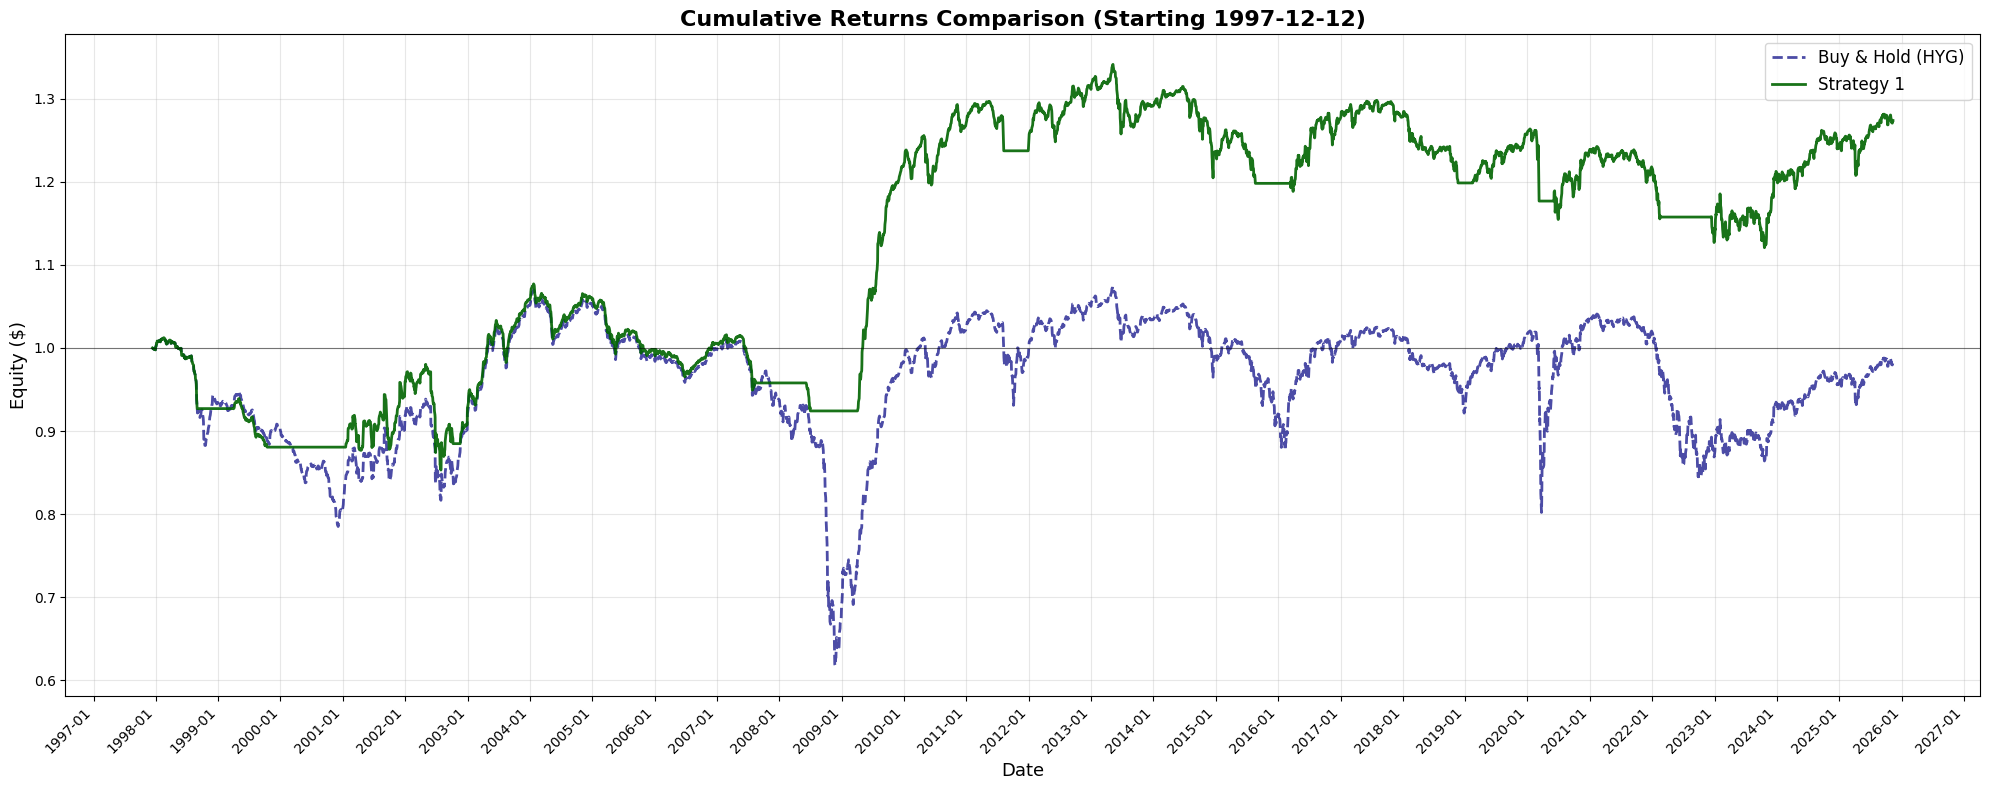


Recent Performance (Last 20 days):
               HYG  HYG_return  HYG_signal  HYG_strat1_return  bah_norm  \
Date                                                                      
2025-10-15  100.04    0.003410           1           0.003410  0.983484   
2025-10-16   99.99   -0.000500           1          -0.000500  0.982993   
2025-10-17   99.91   -0.000800           1          -0.000800  0.982206   
2025-10-20  100.04    0.001301           1           0.001301  0.983484   
2025-10-21  100.09    0.000500           1           0.000500  0.983976   
2025-10-22  100.03   -0.000599           1          -0.000599  0.983386   
2025-10-23  100.05    0.000200           1           0.000200  0.983582   
2025-10-24  100.24    0.001899           1           0.001899  0.985450   
2025-10-27  100.41    0.001696           1           0.001696  0.987122   
2025-10-28  100.40   -0.000100           1          -0.000100  0.987023   
2025-10-29  100.30   -0.000996           1          -0.000996  0

In [ ]:
# Plot cumulative returns comparison
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(plot_data.index, plot_data['bah_norm'], linewidth=2.0, color='navy', 
        label='Buy & Hold (HYG)', alpha=0.7, linestyle='--')
ax.plot(plot_data.index, plot_data['strat1_norm'], linewidth=2.0, color='darkgreen', 
        label='Strategy 1', alpha=0.9)

ax.axhline(y=1, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

ax.set_title(f'Cumulative Returns Comparison (Starting {first_signal_date.strftime("%Y-%m-%d")})', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Equity ($)', fontsize=13)
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display recent performance
print("\nRecent Performance (Last 20 days):")
print("="*80)
recent_cols = ['HYG', 'HYG_return', 'HYG_signal', 'HYG_strat1_return', 'bah_norm', 'strat1_norm']
print(plot_data[recent_cols].tail(20))

In [ ]:
# Calculate Strategy 2 signal statistics
signal_counts_s2 = portfolio['HYG_signal_s2'].value_counts()
long_pct_s2 = signal_counts_s2.get(1, 0) / len(portfolio) * 100
out_pct_s2 = signal_counts_s2.get(0, 0) / len(portfolio) * 100

# Calculate signal transitions for Strategy 2
portfolio['Signal_Change_s2'] = portfolio['HYG_signal_s2'].diff()
transitions_s2 = portfolio[portfolio['Signal_Change_s2'] != 0].copy()

# Count override periods in plot data
override_days_plot = (dd_diff[plot_data.index] > drawdiffthresh).sum()

# Save results to CSV
portfolio.to_csv('strategy1_and_2_results.csv')
print("Results saved to: strategy1_and_2_results.csv")

# Final summary
print("\n" + "="*85)
print("STRATEGIES 1 & 2 FINAL SUMMARY")
print("="*85)
print(f"\nData Period: {portfolio.index.min().strftime('%Y-%m-%d')} to {portfolio.index.max().strftime('%Y-%m-%d')}")
print(f"Total Trading Days: {len(portfolio)}")
print(f"Strategy Period: {plot_data.index.min().strftime('%Y-%m-%d')} to {plot_data.index.max().strftime('%Y-%m-%d')}")

print(f"\n{'='*85}")
print("STRATEGY 1 (BMOM with mom240 filter):")
print(f"{'='*85}")
print(f"  Days Long (signal=1):       {signal_counts.get(1, 0):>6} ({long_pct:>5.1f}%)")
print(f"  Days Out (signal=0):        {signal_counts.get(0, 0):>6} ({out_pct:>5.1f}%)")
print(f"  Number of Transitions:      {len(transitions):>6}")
print(f"  Annualized Return:          {strat1_metrics[1]:>10.2%}")
print(f"  Annualized Volatility:      {strat1_metrics[2]:>10.2%}")
print(f"  Sharpe Ratio:               {strat1_metrics[3]:>10.2f}")

print(f"\n{'='*85}")
print(f"STRATEGY 2 (Strat1 + DD Override @ {drawdiffthresh:.0%}):")
print(f"{'='*85}")
print(f"  Days Long (signal=1):       {signal_counts_s2.get(1, 0):>6} ({long_pct_s2:>5.1f}%)")
print(f"  Days Out (signal=0):        {signal_counts_s2.get(0, 0):>6} ({out_pct_s2:>5.1f}%)")
print(f"  Number of Transitions:      {len(transitions_s2):>6}")
print(f"  Override Days:              {override_days_plot:>6} ({override_days_plot/len(plot_data)*100:>5.1f}%)")
print(f"  Annualized Return:          {strat2_metrics[1]:>10.2%}")
print(f"  Annualized Volatility:      {strat2_metrics[2]:>10.2%}")
print(f"  Sharpe Ratio:               {strat2_metrics[3]:>10.2f}")

print(f"\n{'='*85}")
print("BUY & HOLD (HYG):")
print(f"{'='*85}")
print(f"  Annualized Return:          {bah_metrics[1]:>10.2%}")
print(f"  Annualized Volatility:      {bah_metrics[2]:>10.2%}")
print(f"  Sharpe Ratio:               {bah_metrics[3]:>10.2f}")

print(f"\n{'='*85}")
print("OUTPERFORMANCE vs BUY & HOLD (Annualized):")
print(f"{'='*85}")
print(f"  Strategy 1:                 {(strat1_metrics[1] - bah_metrics[1]):>10.2%}")
print(f"  Strategy 2:                 {(strat2_metrics[1] - bah_metrics[1]):>10.2%}")
print("\n" + "="*85)

print(f"\n{'='*85}")
print("FREE PARAMETERS:")
print(f"{'='*85}")
print(f"  BMOM weights: w1={w1:.2f}, w2={w2:.2f}, w3={w3:.2f}, w4={w4:.2f}")
print(f"  Threshold (thresh): -0.03")
print(f"  DD Threshold (drawdiffthresh): {drawdiffthresh:.2f}")
print(f"  Mom240 length: 240 days")
print("="*85)

Results saved to: strategy1_and_2_results.csv

STRATEGIES 1 & 2 FINAL SUMMARY

Data Period: 1996-12-31 to 2025-11-11
Total Trading Days: 7263
Strategy Period: 1997-12-12 to 2025-11-11

STRATEGY 1 (BMOM with mom240 filter):
  Days Long (signal=1):         5575 ( 76.8%)
  Days Out (signal=0):          1688 ( 23.2%)
  Number of Transitions:          22
  Annualized Return:               0.87%
  Annualized Volatility:           3.57%
  Sharpe Ratio:                     0.26

STRATEGY 2 (Strat1 + DD Override @ 10%):
  Days Long (signal=1):         5754 ( 79.2%)
  Days Out (signal=0):          1509 ( 20.8%)
  Number of Transitions:          22
  Override Days:                 274 (  3.9%)
  Annualized Return:               1.23%
  Annualized Volatility:           4.40%
  Sharpe Ratio:                     0.30

BUY & HOLD (HYG):
  Annualized Return:              -0.07%
  Annualized Volatility:           5.14%
  Sharpe Ratio:                     0.01

OUTPERFORMANCE vs BUY & HOLD (Annualized):

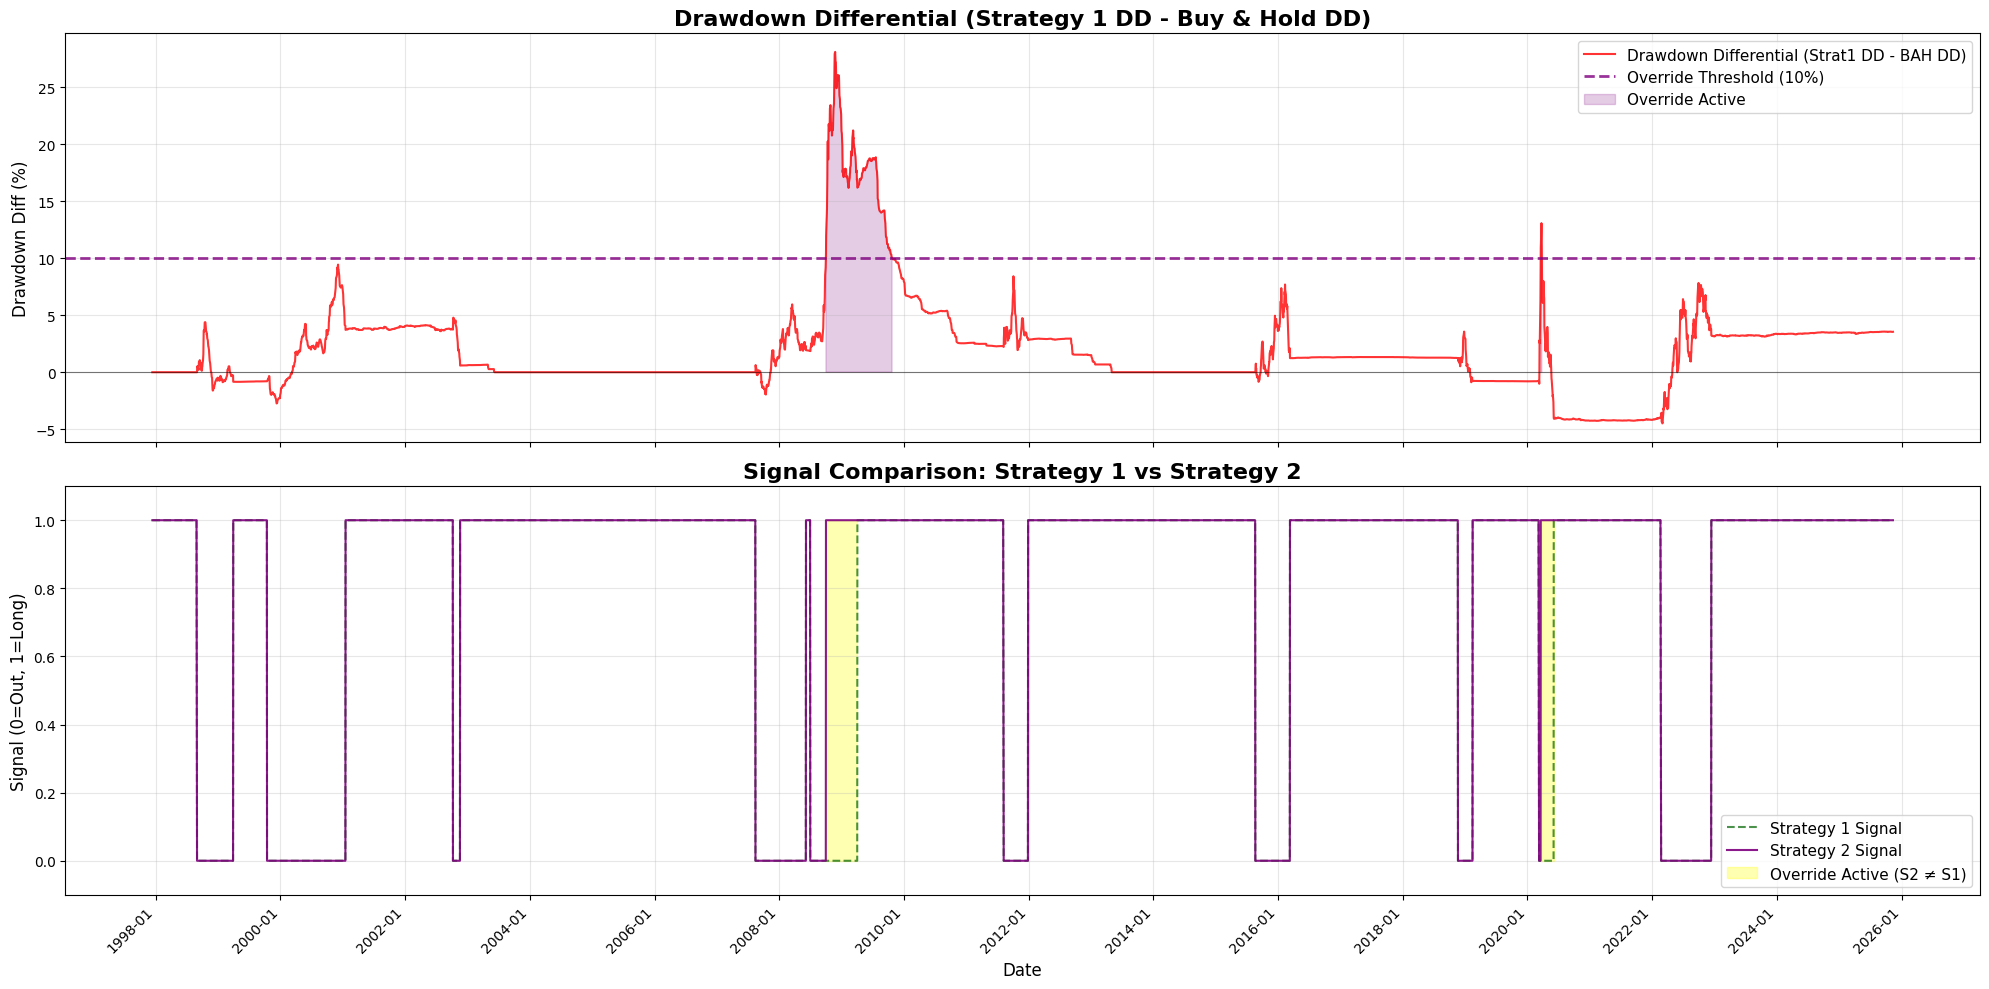


Override Statistics:
  Days where DD diff > 10%:     274 (3.9%)
  Days where S2 signal ≠ S1 signal: 179 (2.5%)
  Total strategy period:             7022 days


In [ ]:
# Plot Strategy 2 Override Analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Calculate DD diff for plot data
plot_data['strat1_dd'] = calculate_drawdown(plot_data['strat1_norm'])
plot_data['bah_dd'] = calculate_drawdown(plot_data['bah_norm'])
plot_data['dd_diff'] = plot_data['strat1_dd'] - plot_data['bah_dd']

# Top plot: Drawdown Differential
ax1.plot(plot_data.index, plot_data['dd_diff'] * 100, linewidth=1.5, color='red', 
        label='Drawdown Differential (Strat1 DD - BAH DD)', alpha=0.8)
ax1.axhline(y=drawdiffthresh * 100, color='purple', linestyle='--', linewidth=2.0, 
           alpha=0.8, label=f'Override Threshold ({drawdiffthresh:.0%})')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Shade override regions
override_mask = plot_data['dd_diff'] > drawdiffthresh
ax1.fill_between(plot_data.index, 0, plot_data['dd_diff'] * 100, 
                where=override_mask, color='purple', alpha=0.2, label='Override Active')

ax1.set_ylabel('Drawdown Diff (%)', fontsize=12)
ax1.set_title('Drawdown Differential (Strategy 1 DD - Buy & Hold DD)', fontsize=16, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom plot: Signal Comparison
ax2.plot(plot_data.index, plot_data['HYG_signal'], linewidth=1.5, color='darkgreen', 
        label='Strategy 1 Signal', alpha=0.7, linestyle='--')
ax2.plot(plot_data.index, plot_data['HYG_signal_s2'], linewidth=1.5, color='purple', 
        label='Strategy 2 Signal', alpha=0.9)

# Highlight override periods
override_diff = plot_data['HYG_signal_s2'] != plot_data['HYG_signal']
ax2.fill_between(plot_data.index, 0, 1, where=override_diff, 
                color='yellow', alpha=0.3, label='Override Active (S2 ≠ S1)')

ax2.set_ylim(-0.1, 1.1)
ax2.set_ylabel('Signal (0=Out, 1=Long)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_title('Signal Comparison: Strategy 1 vs Strategy 2', fontsize=16, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

# Format x-axis
ax2.xaxis.set_major_locator(mdates.YearLocator(2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Count override periods
override_days_plot = (plot_data['dd_diff'] > drawdiffthresh).sum()
signal_diff_days = (plot_data['HYG_signal_s2'] != plot_data['HYG_signal']).sum()

print(f"\nOverride Statistics:")
print(f"  Days where DD diff > {drawdiffthresh:.0%}:     {override_days_plot} ({override_days_plot/len(plot_data)*100:.1f}%)")
print(f"  Days where S2 signal ≠ S1 signal: {signal_diff_days} ({signal_diff_days/len(plot_data)*100:.1f}%)")
print(f"  Total strategy period:             {len(plot_data)} days")

## Step 8: Plot Cumulative Returns Comparison

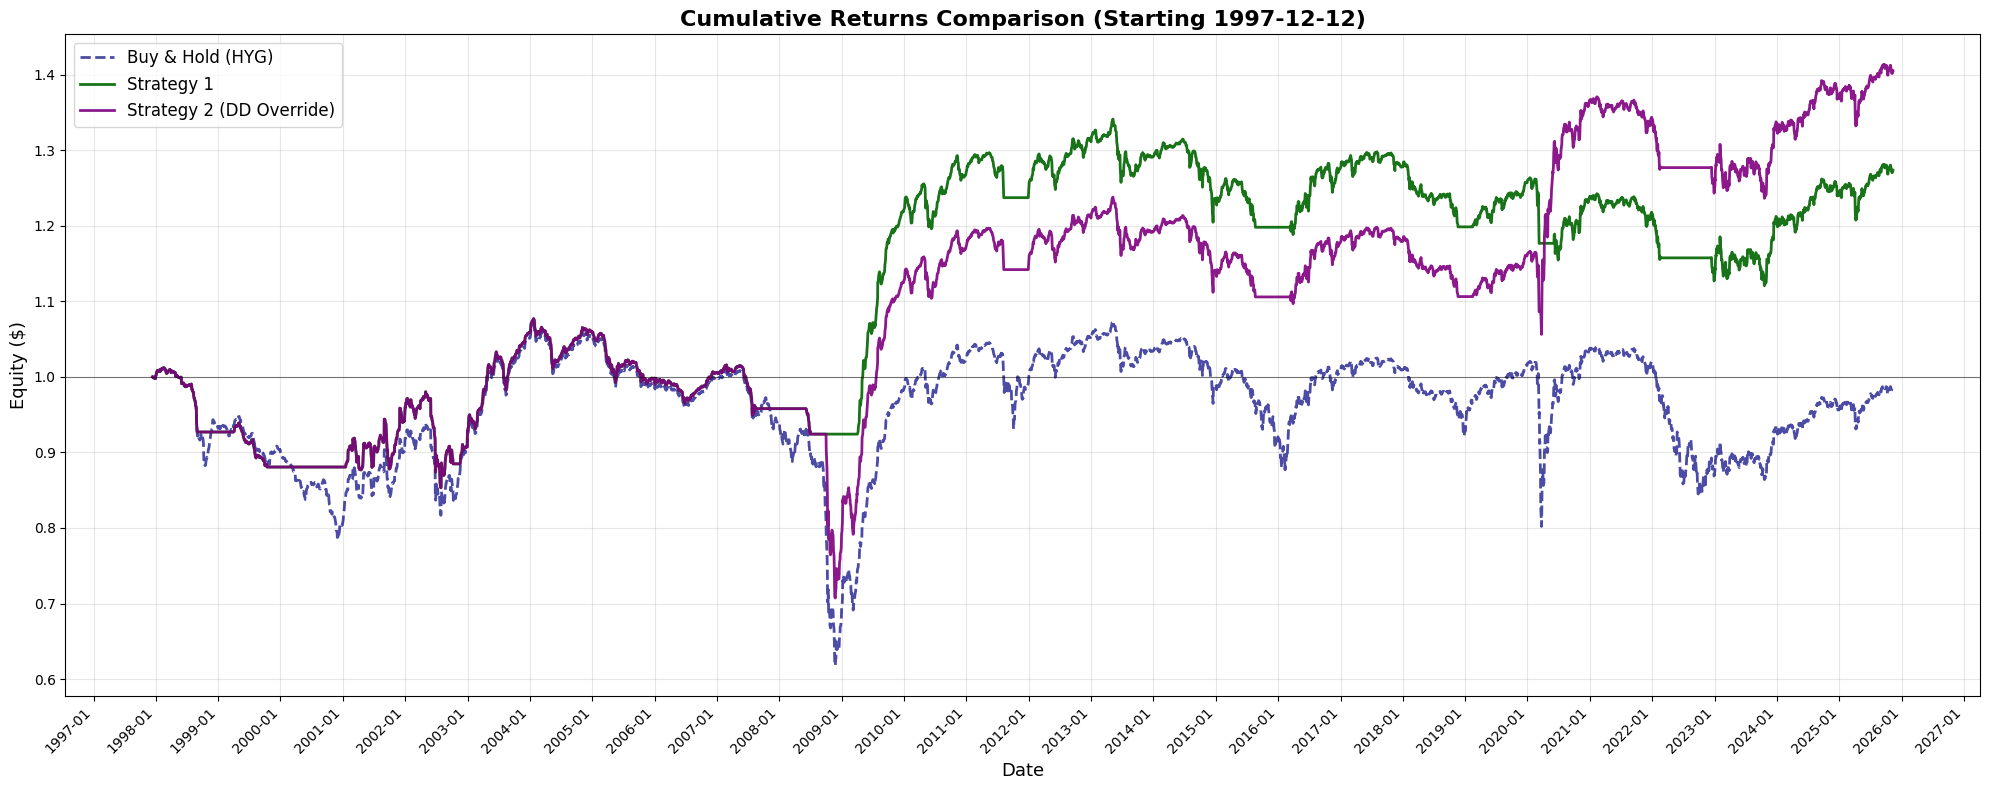


Recent Performance (Last 20 days):
               HYG  HYG_return  HYG_signal  HYG_signal_s2  bah_norm  \
Date                                                                  
1997-12-12  101.72    0.000590           1              1  1.000000   
1997-12-15  101.67   -0.000492           1              1  0.999508   
1997-12-16  101.68    0.000098           1              1  0.999607   
1997-12-17  101.61   -0.000688           1              1  0.998919   
1997-12-18  101.65    0.000394           1              1  0.999312   
1997-12-19  101.67    0.000197           1              1  0.999508   
1997-12-22  101.61   -0.000590           1              1  0.998919   
1997-12-23  101.54   -0.000689           1              1  0.998230   
1997-12-24  101.52   -0.000197           1              1  0.998034   
1997-12-26  101.52    0.000000           1              1  0.998034   
1997-12-29  101.51   -0.000099           1              1  0.997936   
1997-12-30  101.49   -0.000197           

In [ ]:
# Plot cumulative returns comparison
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(plot_data.index, plot_data['bah_norm'], linewidth=2.0, color='navy', 
        label='Buy & Hold (HYG)', alpha=0.7, linestyle='--')
ax.plot(plot_data.index, plot_data['strat1_norm'], linewidth=2.0, color='darkgreen', 
        label='Strategy 1', alpha=0.9)
ax.plot(plot_data.index, plot_data['strat2_norm'], linewidth=2.0, color='purple', 
        label='Strategy 2 (DD Override)', alpha=0.9)

ax.axhline(y=1, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

ax.set_title(f'Cumulative Returns Comparison (Starting {first_signal_date.strftime("%Y-%m-%d")})', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Equity ($)', fontsize=13)
ax.legend(loc='best', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display recent performance
print("\nRecent Performance (Last 20 days):")
print("="*100)
recent_cols = ['HYG', 'HYG_return', 'HYG_signal', 'HYG_signal_s2', 'bah_norm', 'strat1_norm', 'strat2_norm']
print(plot_data[recent_cols].head(20))

## Step 9: Save Results

In [ ]:
# Save signal CSVs with Equity column
strategy1_output = portfolio[['HYG_signal', 'strat1_equity']].copy()
strategy1_output.columns = ['Signal', 'Equity']
strategy1_output.to_csv('strategy1_results.csv')

strategy2_output = portfolio[['HYG_signal_s2', 'strat2_equity']].copy()
strategy2_output.columns = ['Signal', 'Equity']
strategy2_output.to_csv('strategy2_results.csv')

print("CSVs saved: strategy1_results.csv, strategy2_results.csv")
print("Columns: Date, Signal, Equity")

# Calculate all metrics from the plot_data (filtered from first signal date)
print("\n" + "="*80)
print("FINAL PERFORMANCE SUMMARY")
print("="*80)
print(f"Period: {plot_data.index.min().strftime('%Y-%m-%d')} to {plot_data.index.max().strftime('%Y-%m-%d')}")
print(f"Trading Days: {len(plot_data)}")
print("\n" + "="*80)
print(f"{'Strategy':<20} {'Total Ret':>12} {'Ann Ret':>12} {'Vol':>12} {'Sharpe':>10}")
print("="*80)
print(f"{'Strategy 1':<20} {strat1_metrics[0]:>11.2%} {strat1_metrics[1]:>11.2%} {strat1_metrics[2]:>11.2%} {strat1_metrics[1]/strat1_metrics[2]:>10.2f}")
print(f"{'Strategy 2':<20} {strat2_metrics[0]:>11.2%} {strat2_metrics[1]:>11.2%} {strat2_metrics[2]:>11.2%} {strat2_metrics[1]/strat2_metrics[2]:>10.2f}")
print(f"{'Buy & Hold HYG':<20} {bah_metrics[0]:>11.2%} {bah_metrics[1]:>11.2%} {bah_metrics[2]:>11.2%} {bah_metrics[1]/bah_metrics[2]:>10.2f}")
print("="*80)

CSVs saved: strategy1_results.csv, strategy2_results.csv
Columns: Date, Signal, Equity

FINAL PERFORMANCE SUMMARY
Period: 1997-12-12 to 2025-11-11
Trading Days: 7022

Strategy                Total Ret      Ann Ret          Vol     Sharpe
Strategy 1                27.37%       0.87%       3.57%       0.24
Strategy 2                40.51%       1.23%       4.40%       0.28
Buy & Hold HYG            -1.80%      -0.07%       5.14%      -0.01
